In [280]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

In [281]:
# Data preparation
data = {
    'Model': ['Qwen 2.5 Coder', 'GPT-4.1', 'GPT-5', 'DeepSeek-V3', 'GPT-OSS', 'Llama-4 Maverick', 'Codestral'],
    'ClassEval': [83.60, 88.27, 87.11, 87.00, 86.76, 84.65, 85.35],
    'Pre-Cutoff': [30.75, 30.12, 26.75, 32.55, 24.59, 28.27, 33.60],
    'Post-Cutoff': [29.40, 30.84, 29.04, 31.00, 28.48, 27.40, 27.98]
}

df = pd.DataFrame(data)
df.set_index('Model', inplace=True)


In [282]:
df.sort_index(ascending=True, inplace=True)

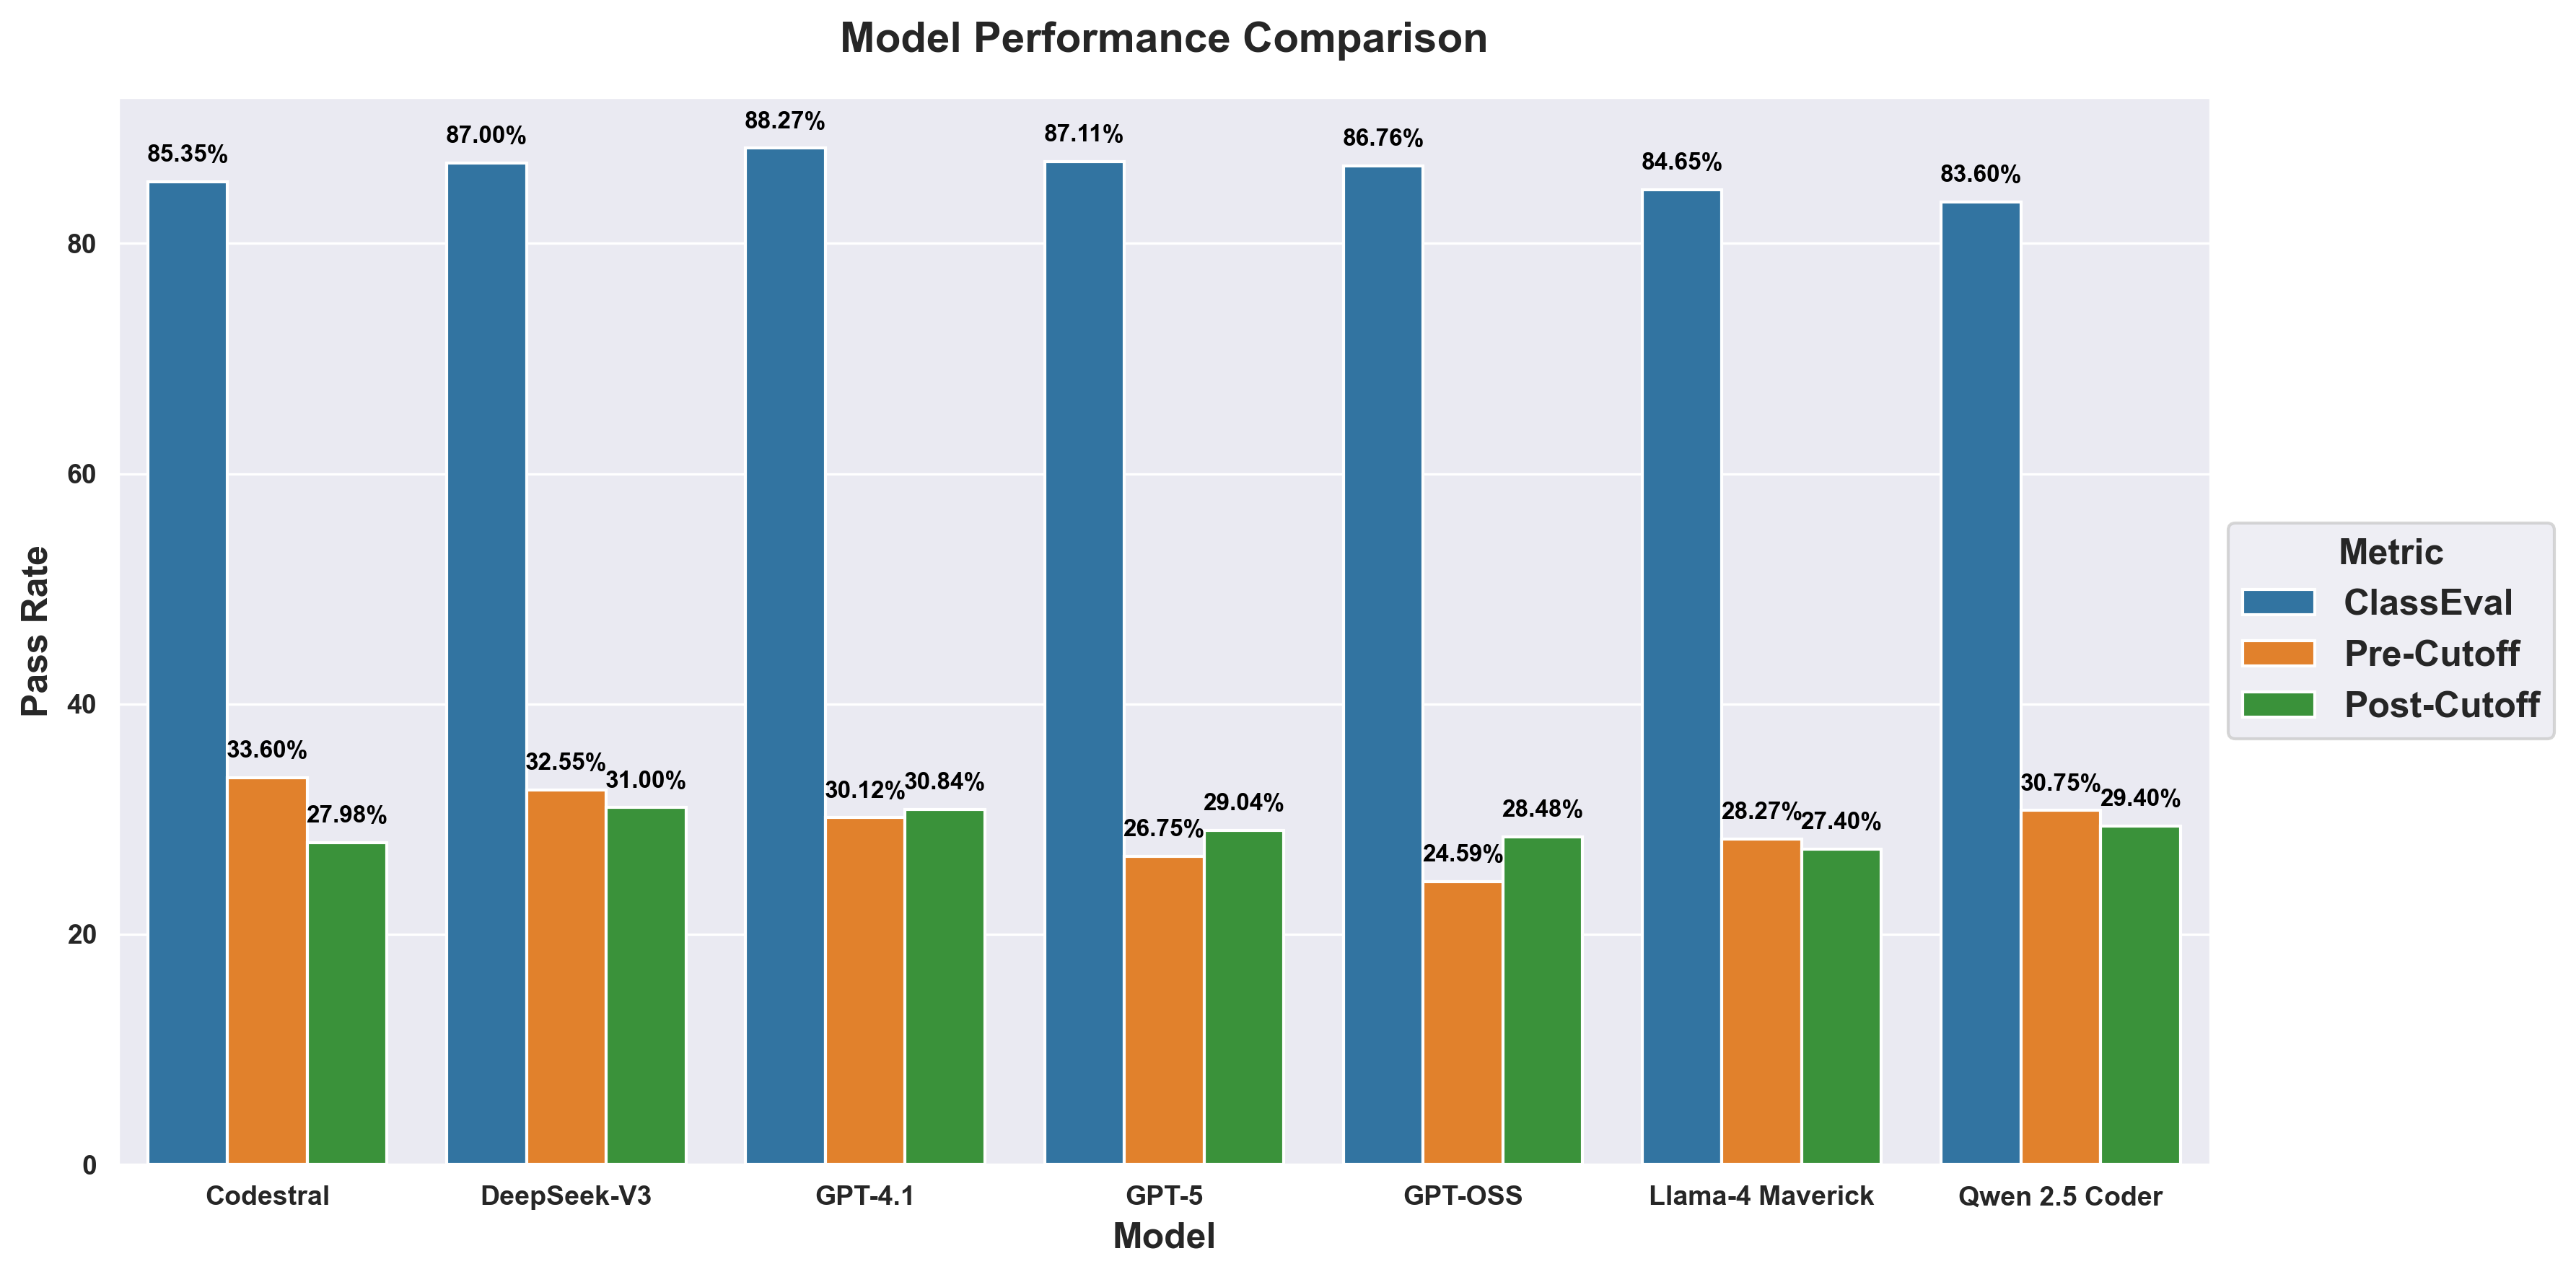

In [284]:
#  Melt the DataFrame to long format for Seaborn
df_melted = df.reset_index().melt(id_vars='Model',
                                 value_vars=['ClassEval', 'Pre-Cutoff', 'Post-Cutoff'],
                                 var_name='Metric',
                                 value_name='Score')

# Create the bar chart
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_melted, x='Model', y='Score', hue='Metric')

# Add percentage labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only add labels for non-zero heights
        ax.annotate(f'{height:.2f}%',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=8, color='black',
                    xytext=(0, 5), textcoords='offset points', fontweight='bold')

# Customize the plot
plt.title('Model Performance Comparison', fontsize=14, pad=15, fontweight='bold')
plt.xlabel('Model', fontsize=12, fontweight='bold')
plt.ylabel('Pass Rate', fontsize=12, fontweight='bold')
plt.xticks(ha='center', fontweight='bold')
plt.yticks(fontweight='bold')
font_properties = {'weight': 'bold', 'size': 12}
legend = plt.legend(title='Metric', loc='center left', bbox_to_anchor=(1.0, 0.5), prop = font_properties)
# Create a FontProperties object with bold weight
bold_font = FontProperties(weight='bold', size=12)

# Apply the bold font to the legend title
legend.set_title(legend.get_title().get_text(), prop=bold_font)
plt.tight_layout()

# Save the plot as a PDF with 300 DPI
plt.savefig('../results/plots_for_paper/model_performance.pdf', dpi=300, format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

In [311]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Define model names: folder names (for file access) and display names (for plot)
model_mapping = {
    'codestral': 'Codestral',
    'deepseek-ai': 'Deepseek-V3',
    'gpt-4.1': 'GPT-4.1',
    'gpt-5': 'GPT-5',
    'openai': 'GPT-OSS',
    'meta-llama': 'Llama 4 Maverick',
    'Qwen': 'Qwen Coder 2.5'
}
models = list(model_mapping.keys())  # Folder names: ['codestral', 'deepseek-ai', 'gpt-4.1', 'gpt-5', 'openai', 'meta-llama', 'Qwen']
display_order = list(model_mapping.values())  # Display names in RQ1 order: ['Codestral', 'Deepseek-V3', 'GPT-4.1', 'GPT-5', 'GPT-OSS', 'Llama 4 Maverick', 'Qwen Coder 2.5']
data_versions = ['csn', 'post_cut-off']
docstring_types = ['full', 'partial', 'no']

# Function to compute per-snippet pass rates from test reports
def compute_pass_rates(data_version, model, docstr_type):
    file_path = f"../functional_correctness_test_folder/{data_version}/{model}/{docstr_type}_docstr_reports/combined_test_report.csv"
    try:
        df = pd.read_csv(file_path)
        df = df[df['markers'].isna()]  # Filter xfail test cases
        final_list = []
        for snippet in df['module'].unique():
            tmp_list = [snippet.split(".")[-1]]
            passed = df[(df['module'] == snippet) & (df['status'] == 'passed')].shape[0]
            failed = df[(df['module'] == snippet) & (df['status'] == 'failed')].shape[0]
            total = passed + failed
            if total > 0:
                tmp_list.extend([passed, failed, total, passed / total])
                final_list.append(tmp_list)
        result_df = pd.DataFrame(final_list, columns=['snippet', f'passed_{docstr_type}', f'failed_{docstr_type}', f'total_test_case_{docstr_type}', f'pass_rate_{docstr_type}'])
        result_df['model'] = model_mapping[model]  # Use display name
        result_df['dataset'] = data_version
        return result_df
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

# Collect pass rate data for all models and datasets
all_dfs = []
for data_version in data_versions:
    for model in models:
        # Compute pass rates for each docstring condition
        full_df = compute_pass_rates(data_version, model, 'full')
        partial_df = compute_pass_rates(data_version, model, 'partial')
        no_df = compute_pass_rates(data_version, model, 'no')

        if full_df is None or partial_df is None or no_df is None:
            continue

        # Merge DataFrames on snippet
        merged_df = pd.merge(full_df, partial_df, on=['snippet', 'model', 'dataset'], how='inner')
        merged_df = pd.merge(merged_df, no_df, on=['snippet', 'model', 'dataset'], how='inner')

        # Validate snippet alignment
        snippets_full = set(full_df['snippet'])
        snippets_partial = set(partial_df['snippet'])
        snippets_no = set(no_df['snippet'])
        common_snippets = snippets_full.intersection(snippets_partial, snippets_no)
        print(f"Common snippets for {model_mapping[model]} ({data_version}): {len(common_snippets)}")
        if len(common_snippets) < min(len(snippets_full), len(snippets_partial), len(snippets_no)):
            print(f"Warning: Dropped snippets - Full: {len(snippets_full)}, Partial: {len(snippets_partial)}, No: {len(snippets_no)}")

        all_dfs.append(merged_df)

# Combine all data
if not all_dfs:
    raise ValueError("No valid data found for any model-dataset combination.")
combined_df = pd.concat(all_dfs, ignore_index=True)

# Reshape data for violin plot (melt to long format)
df_melted = pd.melt(
    combined_df,
    id_vars=['model', 'dataset', 'snippet'],
    value_vars=['pass_rate_full', 'pass_rate_partial', 'pass_rate_no'],
    var_name='docstring_condition',
    value_name='pass_rate'
)

# Map docstring conditions for readability
df_melted['docstring_condition'] = df_melted['docstring_condition'].map({
    'pass_rate_full': 'Full',
    'pass_rate_partial': 'Partial',
    'pass_rate_no': 'No'
})

# Map dataset for clarity
df_melted['dataset'] = df_melted['dataset'].map({
    'csn': 'Pre-Cutoff',
    'post_cut-off': 'Post-Cutoff'
})

# Ensure model order matches RQ1 report
df_melted['model'] = pd.Categorical(
    df_melted['model'],
    categories=display_order,
    ordered=True
)

# Create violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(
    x='docstring_condition',
    y='pass_rate',
    hue='dataset',
    split=True,
    data=df_melted,
    palette={'Pre-Cutoff': '#1f77b4', 'Post-Cutoff': '#ff7f0e'},
    inner='quart',
    density_norm='count', fill=True, orient = 'v'
)

# Customize plot
plt.title('Pass Rate Distributions Across Docstring Conditions', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Docstring Condition', fontsize=12, fontweight='bold')
plt.ylabel('Pass Rate (Proportion of Tests Passed)', fontsize=12, fontweight='bold')
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.ylim(-0.25, 1.25)
font_properties = {'weight': 'bold', 'size': 12}
legend = plt.legend(title='Dataset', loc='center left', bbox_to_anchor=(1.0, 0.5), prop = font_properties)
# Create a FontProperties object with bold weight
bold_font = FontProperties(weight='bold', size=12)
# Apply the bold font to the legend title
legend.set_title(legend.get_title().get_text(), prop=bold_font)

# Ensure output directory exists
output_dir = "../results/plots_for_paper/"
os.makedirs(output_dir, exist_ok=True)

# Save plot
output_path = os.path.join(output_dir, 'pass_rate_violins.pdf')
plt.savefig(output_path, format='pdf', bbox_inches='tight', dpi=300)
plt.close()

print(f"Violin plot saved to {output_path}")

Common snippets for Codestral (csn): 169
Common snippets for Deepseek-V3 (csn): 178
Common snippets for GPT-4.1 (csn): 189
Common snippets for GPT-5 (csn): 185
Common snippets for GPT-OSS (csn): 165
Common snippets for Llama 4 Maverick (csn): 175
Common snippets for Qwen Coder 2.5 (csn): 175
Common snippets for Codestral (post_cut-off): 174
Common snippets for Deepseek-V3 (post_cut-off): 190
Common snippets for GPT-4.1 (post_cut-off): 212
Common snippets for GPT-5 (post_cut-off): 206
Common snippets for GPT-OSS (post_cut-off): 182
Common snippets for Llama 4 Maverick (post_cut-off): 200
Common snippets for Qwen Coder 2.5 (post_cut-off): 192
Violin plot saved to ../results/plots_for_paper/pass_rate_violins.pdf


In [312]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the RQ3 results CSV
results_df = pd.read_csv('../results/rq3/rq3_results.csv')

# Create a combined condition column for x-axis (model + docstr_type)
results_df['condition'] = results_df['model'] + '_' + results_df['docstr_type']

# Set the style for better visualization
sns.set_style("whitegrid")

# Create the box plot
plt.figure(figsize=(12, 6))
box_plot = sns.boxplot(x='condition', y='mean_diff', hue='docstr_type', data=results_df,
                       palette={'full': 'blue', 'partial': 'green', 'no': 'red'},
                       dodge=False)  # dodge=False to stack by condition within model

# Customize the plot
plt.xticks(rotation=45, ha='right')
plt.title('Box Plot of Mean Pass Rate Differences by Model and Docstring Condition')
plt.ylabel('Mean Pass Rate Difference (0–1)')
plt.xlabel('Model and Docstring Condition')
plt.legend(title='Docstring Condition', loc='upper right')

# Annotate significant p_raw values (< 0.05)
for i, row in results_df.iterrows():
    if row['p_raw'] < 0.05:
        plt.text(i, row['mean_diff'] + 0.01, f'p_raw={row["p_raw"]:.3f}',
                 ha='center', va='bottom', fontsize=8, color='black')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the plot
os.makedirs('../results/plots_for_paper', exist_ok=True)
plt.savefig('../results/plots_for_paper/rq3_box_plot.png', dpi=300, bbox_inches='tight')
plt.close()

print("Box plot saved as ../results/plots_for_paper/rq3_box_plot.png")

Box plot saved as ../results/plots_for_paper/rq3_box_plot.png


/var/folders/jf/3mnp98hs2tl_xp62qlcj7cdc0000gn/T/ipykernel_8891/1958675990.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=10)


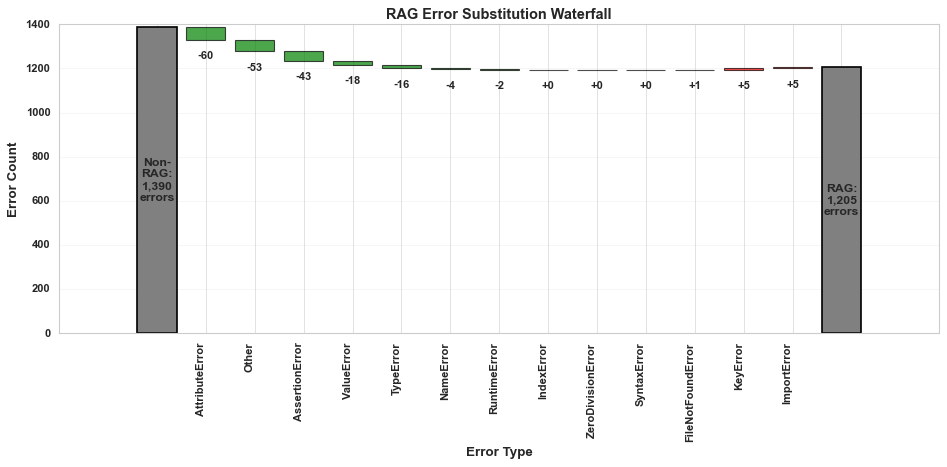

In [361]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load RAG substitution data
df = pd.read_csv('../results/rq4/rag_substitution_aggregate.csv', index_col=0)
df = df.sort_values('Absolute_Diff')

# Prepare waterfall data
changes = df['Absolute_Diff'].values
error_types = df.index.tolist()

# Calculate cumulative positions
cumulative = np.append(1390, 1390 + np.cumsum(changes))

# Create waterfall
fig, ax = plt.subplots(figsize=(12, 6))

# Starting bar
ax.bar(0, 1390, color='gray', edgecolor='black', linewidth=1.5)
ax.text(0, 1390/2, 'Non-\nRAG:\n1,390\nerrors', ha='center', va='center', fontweight='bold', fontsize=11)

# Change bars
for i, (error, change) in enumerate(zip(error_types, changes)):
    color = 'green' if change < 0 else 'red'
    bottom = min(cumulative[i], cumulative[i+1])
    height = abs(change)
    ax.bar(i+1, height, bottom=bottom, color=color, alpha=0.7, edgecolor='black')
    # Add labels below each box
    label_y = bottom - 50  # Position below the box
    ax.text(i+1, label_y, f'{int(change):+d}', ha='center', va='top', fontweight='bold', fontsize=10)

# Ending bar
ax.bar(len(changes)+1, 1205, color='gray', edgecolor='black', linewidth=1.5)
ax.text(len(changes)+1, 1205/2, 'RAG:\n1,205\nerrors', ha='center', va='center', fontweight='bold', fontsize=11)

# Formatting
ax.set_xticks(range(len(changes)+2))
ax.set_xticklabels([''] + error_types + [''], rotation=90, ha='right')
ax.set_ylabel('Error Count', fontsize=12, fontweight='bold')
ax.set_xlabel('Error Type', fontsize=12, fontweight='bold')  # Added x-label
ax.set_title('RAG Error Substitution Waterfall', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Bold x and y tick labels
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold', fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=10)

# If you add a legend later, make it bold like this:
# legend = ax.legend(loc='best', fontsize=11)
# legend.get_title().set_fontweight('bold')
# for text in legend.get_texts():
#     text.set_fontweight('bold')

plt.tight_layout()
plt.savefig('../results/plots_for_paper/rag_error_waterfall.pdf', dpi=300, bbox_inches='tight')
plt.show()

/var/folders/jf/3mnp98hs2tl_xp62qlcj7cdc0000gn/T/ipykernel_8891/1419574449.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold', fontsize=11)


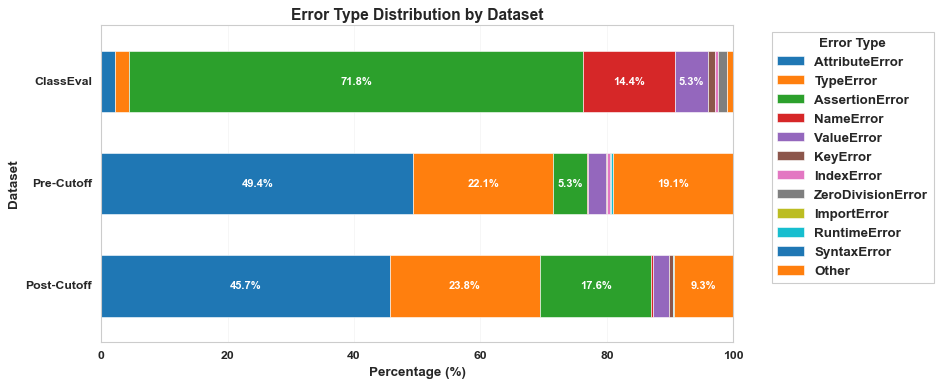

In [352]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Load data
df = pd.read_csv('../results/rq4/dataset_error_distributions.csv', index_col=0)

# Create "Other" category from small error types if needed
# Get all columns except the main ones we want to show individually
main_errors = ['AttributeError', 'TypeError', 'AssertionError', 'NameError',
               'ValueError', 'KeyError', 'IndexError', 'ZeroDivisionError',
               'ImportError', 'RuntimeError', 'SyntaxError']

# Check which columns exist
existing_errors = [col for col in main_errors if col in df.columns]
other_cols = [col for col in df.columns if col not in existing_errors]

if other_cols:
    df['Other'] = df[other_cols].sum(axis=1)
    df_plot = df[existing_errors + ['Other']]
else:
    df_plot = df[existing_errors]

# Rename index
df_plot.index = ['ClassEval', 'Pre-Cutoff', 'Post-Cutoff']

# Create horizontal stacked bar chart
fig, ax = plt.subplots(figsize=(12, 5))
colors = sns.color_palette("tab10", n_colors=len(df_plot.columns))

df_plot.plot(kind='barh', stacked=True, ax=ax,
             color=colors, width=0.6, edgecolor='white', linewidth=0.5)

# Add percentage labels where there's enough space
for i, dataset in enumerate(df_plot.index):
    cumulative = 0
    for j, error_type in enumerate(df_plot.columns):
        value = df_plot.loc[dataset, error_type]
        # Only show percentage if segment is large enough (>3%)
        if value > 3:
            x_pos = cumulative + value / 2
            ax.text(x_pos, i, f'{value:.1f}%',
                   ha='center', va='center',
                   fontsize=10, fontweight='bold', color='white')
        cumulative += value

ax.set_xlabel('Percentage (%)', fontsize=12, weight='bold')
ax.set_ylabel('Dataset', fontsize=12, weight='bold')
ax.set_title('Error Type Distribution by Dataset', fontsize=14, fontweight='bold')

# Create legend and make all text bold
legend = ax.legend(title='Error Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
legend.get_title().set_fontweight('bold')
legend.get_title().set_fontsize(12)
for text in legend.get_texts():
    text.set_fontweight('bold')

ax.set_xlim(0, 100)
ax.grid(axis='x', alpha=0.3)
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold', fontsize=11)
ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold', fontsize=11)
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('../results/plots_for_paper/error_distribution_by_dataset.pdf',
            dpi=300, bbox_inches='tight')
plt.show()